### Trying to understand condition-specific regulator clusters
#### (1) Is it because regulators or downstream genes are only expressed in one/some conditions?
#### (2) Is this mainly a quantitative effect: quantitative change in expression alters power and/or regulatory connections become stronger

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage
from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data'

In [4]:
adata_de = sc.read_h5ad(datadir + f'/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_summary_stats.baseMean = de_summary_stats.baseMean.fillna(0)
de_summary_stats = de_summary_stats.set_index('obs_names')
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)

In [5]:
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)

## Check regulator expression across clusters

In [5]:
all_gene = set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean

df = all_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

### Overall regulator expression difference

In [10]:
df_exp = pd.DataFrame(index=adata_final.obs['hdbscan'].unique().tolist())
for cl in adata_final.obs['hdbscan'].unique():
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3
df_exp['regulator_stim8_rest_diff'] = df_exp['regulator_stim8_rest_diff'].fillna(0)
df_exp['regulator_stim48_rest_diff'] = df_exp['regulator_stim48_rest_diff'].fillna(0)
df_exp['regulator_stim48_stim8_diff'] = df_exp['regulator_stim48_stim8_diff'].fillna(0)
df_exp['regulator_stim8_rest_p'] = df_exp['regulator_stim8_rest_p'].fillna(1)
df_exp['regulator_stim48_rest_p'] = df_exp['regulator_stim48_rest_p'].fillna(1)
df_exp['regulator_stim48_stim8_p'] = df_exp['regulator_stim48_stim8_p'].fillna(1)

# Multiple test correction
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [52]:
cluster_order = [106, 27, 105, 101, 84, 104, 30, 60,
                 21, 22, 99, 93, 
                 103, 36, 77, 107, 102, 111,
                 7, 62,
                 98, 46, 91, 33, 108, 61, 31, 32, 15, 28, 58,
                 68, 48, 74, 38,
                 34, 8, 2, 83, 9, 10, 0, 65, 66, 81]

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_14077/1752337554.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


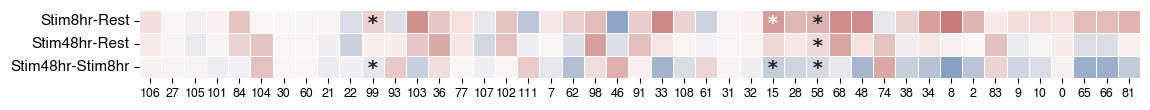

In [59]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(11.6, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T,
            vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('results/cluster_by_condition/regulator_exp_all_regulators.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Plot colormap

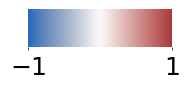

In [48]:
thres = 1
orientation = 'bottom'
colormap = 'vlag'
cmap = sns.color_palette(colormap, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-thres, thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres)+orientation+'_'+colormap+'.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Individual cluster regulator expression

In [11]:
cl = 27

regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()

# (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
regulator = [item for item in regulator if item in adata_de.var_names]

regulator_baseMean_df = pd.DataFrame(index=regulator)
regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_40446/3001937057.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=20)


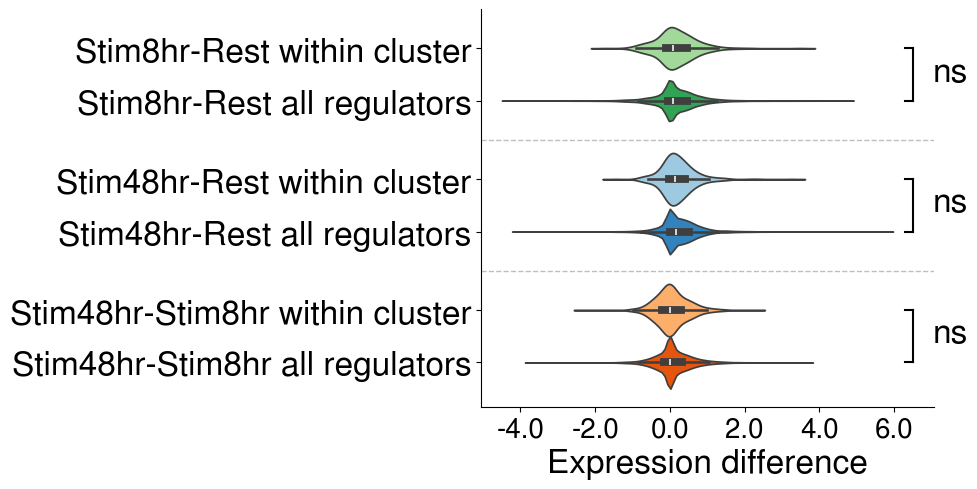

In [167]:
rest = regulator_baseMean_df['baseMean_Rest']
stim8 = regulator_baseMean_df['baseMean_Stim8hr']
stim48 = regulator_baseMean_df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest = log_stim8 - log_rest
stim48_rest = log_stim48 - log_rest
stim48_stim8 = log_stim48 - log_stim8

p_value1, p_value2, p_value3 = df_exp.loc[cl, ['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]

# Parse into DataFrame
data_frames_to_concat = [
    # Stim8hr vs Rest Comparison
    pd.DataFrame({'Value': stim8_rest, 'Comparison': 'stim8_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim8_rest_all, 'Comparison': 'stim8_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_rest, 'Comparison': 'stim48_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_rest_all, 'Comparison': 'stim48_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_stim8, 'Comparison': 'stim48_stim8', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_stim8_all, 'Comparison': 'stim48_stim8', 'Set': 'all regulators'}),
]

df = pd.concat(data_frames_to_concat, ignore_index=True)

# Plot violinplot
fig, ax = plt.subplots(figsize=(10, 5))
vp = sns.violinplot(data=df, x='Value', y='Comparison', hue='Set', ax=ax)
for i, collection in enumerate(vp.collections):
    collection.set_facecolor(colors[i])
ax.get_legend().remove()

# Plot significance
def get_sig_text(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

y_positions = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2]
x_position = 6.5
line_x_offset = 0.2
ax.plot([x_position, x_position], [y_positions[0], y_positions[1]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[0], y_positions[0]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[1], y_positions[1]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[0]+0.3, f'{get_sig_text(p_value1)}', 
        ha='center', va='bottom', fontsize=24)

ax.plot([x_position, x_position], [y_positions[2], y_positions[3]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[2], y_positions[2]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[3], y_positions[3]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[2]+0.3, f'{get_sig_text(p_value2)}', 
        ha='center', va='bottom', fontsize=24)

line_x3 = 6
ax.plot([x_position, x_position], [y_positions[4], y_positions[5]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[4], y_positions[4]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[5], y_positions[5]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[4]+0.3, f'{get_sig_text(p_value3)}', 
        ha='center', va='bottom', fontsize=24)


ax.set_yticks(y_positions)
ax.set_yticklabels(['Stim8hr-Rest within cluster', 'Stim8hr-Rest all regulators',
                   'Stim48hr-Rest within cluster', 'Stim48hr-Rest all regulators', 
                   'Stim48hr-Stim8hr within cluster', 'Stim48hr-Stim8hr all regulators'], fontsize=24)

ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlabel('Expression difference', fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'regulator_exp.pdf', dpi=600,
           bbox_inches='tight', pad_inches=0)

In [164]:
all_gene = []
top_perc = 0.025
for cl in adata_final.obs.hdbscan.unique():
    rank_cutoff = len(downstream_gene_df[downstream_gene_df.hdbscan_cluster==cl])*top_perc
    mask = (downstream_gene_df.hdbscan_cluster==cl)&((downstream_gene_df['zscore_rank_negative_regulation']<rank_cutoff)|(downstream_gene_df['zscore_rank_positive_regulation']<rank_cutoff))
    all_gene = all_gene + downstream_gene_df[mask].downstream_gene_ids.tolist()

all_gene = set(all_gene) \
& set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean

df = all_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

In [273]:
len(regulator), len(set(regulator))

(129, 127)

In [315]:
df_exp = pd.DataFrame(index=downstream_gene_df['hdbscan_cluster'].unique().tolist())
for cl in downstream_gene_df['hdbscan_cluster'].unique():
    # For each cluster, choose the top 10% down-regulated genes and 10% up-regulated genes for analysis
    rank_cutoff = len(downstream_gene_df[downstream_gene_df['hdbscan_cluster']==cl])*top_perc
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=rank_cutoff) | (downstream_gene_df['zscore_rank_positive_regulation']<=rank_cutoff))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    downstream_gene_baseMean_df = pd.DataFrame(index=downstream_gene)
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean

    df = downstream_gene_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)
    
    df_exp.loc[cl, 'downstream_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'downstream_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'downstream_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'downstream_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'downstream_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'downstream_stim48_stim8_p'] = p_value3
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3

In [316]:
df_exp[['downstream_stim8_rest_p','downstream_stim48_rest_p','downstream_stim48_stim8_p',
        'regulator_stim8_rest_p','regulator_stim48_rest_p','regulator_stim48_stim8_p']] = df_exp[['downstream_stim8_rest_p','downstream_stim48_rest_p','downstream_stim48_stim8_p',
        'regulator_stim8_rest_p','regulator_stim48_rest_p','regulator_stim48_stim8_p']].fillna(1)

In [317]:
df_exp['downstream_stim8_rest_fdr'] = multipletests(df_exp['downstream_stim8_rest_p'])[1]
df_exp['downstream_stim48_rest_fdr'] = multipletests(df_exp['downstream_stim48_rest_p'])[1]
df_exp['downstream_stim48_stim8_fdr'] = multipletests(df_exp['downstream_stim48_stim8_p'])[1]
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [286]:
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
adata_de_obs = adata_de.obs.copy()
cluster_df.columns = ['cluster_gene_size']
cluster_df['corr_rest'] = 0
cluster_df['corr_stim8hr'] = 0
cluster_df['corr_stim48hr'] = 0

for cl in cluster_df.index.unique():
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de_obs[adata_de_obs['target_contrast_corrected'].isin(gene_id_list)].index
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()
    corr_df = corr_df.reset_index()
    corr_df = corr_df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
    cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
    cluster_df.loc[cl, 'corr_stim48hr'] = np.mean(corr_stim48hr)

cluster_df['corr_max'] = cluster_df.iloc[:,1:].max(1)
cluster_df['corr_std'] = cluster_df.iloc[:,1:].std(1)

mask = ((cluster_df.cluster_gene_size>=55)&(cluster_df.corr_max>0.2))|\
((cluster_df.cluster_gene_size<55)&(cluster_df.cluster_gene_size>6)&(cluster_df.corr_max>0.3))|\
((cluster_df.cluster_gene_size==4)&(cluster_df.corr_max>0.375))|\
((cluster_df.cluster_gene_size==6)&(cluster_df.corr_max>0.32))
condition_specificity = cluster_df[mask].copy()
condition_specificity = condition_specificity.sort_index()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03171675341206319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.026276039328289806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03128375786860269' has dtype inc

In [287]:
cluster_order = [81, 66, 65, 0, 9, 10, 83, 2, 8, 34, 
                 38, 74, 48, 68, 
                 15, 28, 58, 31, 32,
                 61, 108, 33, 91, 46,
                 98,
                 62, 7,
                 111, 102, 107, 77, 36, 103,
                 93, 99, 22, 21,
                 60, 30, 104, 84, 101, 105, 27, 106,
                ]

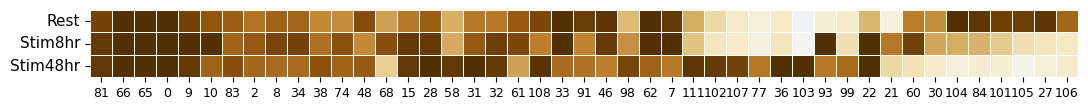

In [322]:
thres = 0.4
fig, ax = plt.subplots(figsize=(11, 1.2))
sns.heatmap(condition_specificity.loc[cluster_order, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, 
            yticklabels=['Rest', 'Stim8hr', 'Stim48hr'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()

In [312]:
df_exp

,downstream_stim8_rest_diff,downstream_stim48_rest_diff,downstream_stim48_stim8_diff,downstream_stim8_rest_p,downstream_stim48_rest_p,downstream_stim48_stim8_p,regulator_stim8_rest_diff,regulator_stim48_rest_diff,regulator_stim48_stim8_diff,regulator_stim8_rest_p,regulator_stim48_rest_p,regulator_stim48_stim8_p,downstream_stim8_rest_fdr,downstream_stim48_rest_fdr,downstream_stim48_stim8_fdr,regulator_stim8_rest_fdr,regulator_stim48_rest_fdr,regulatorstim48_stim8_fdr
21,-0.120268,-0.139536,-0.019268,5.107291e-02,1.298016e-03,5.796201e-01,-0.023684,-0.169055,-0.145371,6.424503e-01,0.000038,1.841156e-04,9.682999e-01,1.080094e-01,1.000000,1.000000e+00,0.004271,1.987038e-02
35,-0.031942,0.000930,0.032872,4.791247e-01,9.818954e-01,3.211419e-01,-0.068202,-0.019374,0.048829,6.254299e-01,0.838965,6.384979e-01,1.000000e+00,1.000000e+00,0.999996,1.000000e+00,1.000000,1.000000e+00
33,0.001976,0.154467,0.152491,9.730136e-01,9.129116e-03,4.580102e-03,0.522767,0.021880,-0.500887,1.517804e-03,0.766946,1.944709e-03,1.000000e+00,5.154392e-01,0.294527,1.525863e-01,1.000000,1.864435e-01
58,0.079021,0.147389,0.068368,6.842777e-02,2.862212e-05,6.634318e-02,0.315570,0.066502,-0.249068,1.770836e-12,0.035304,3.638647e-10,9.876569e-01,2.801078e-03,0.974015,2.001045e-10,0.971512,4.111671e-08
41,0.268213,0.273070,0.004857,3.738656e-10,2.365429e-12,8.794925e-01,0.204749,0.015072,-0.189677,1.848250e-03,0.812678,4.158044e-03,3.962975e-08,2.554664e-10,1.000000,1.811020e-01,1.000000,3.506268e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,-0.343682,-0.062437,0.281244,4.369171e-02,6.362893e-01,2.503101e-02,0.038927,0.210699,0.171772,8.215015e-01,0.399118,6.396602e-01,9.541587e-01,1.000000e+00,0.797502,1.000000e+00,1.000000,1.000000e+00
65,-0.222085,0.179545,0.401630,8.107688e-03,4.514327e-02,1.168716e-07,0.263005,-0.271449,-0.534455,1.617502e-01,0.092708,4.267200e-02,5.034659e-01,9.503426e-01,0.000012,9.999991e-01,0.999826,9.819589e-01
83,-0.595519,-0.258459,0.337060,6.163443e-09,8.129747e-04,2.958572e-04,0.042796,0.208234,0.165438,1.000000e+00,1.000000,1.000000e+00,6.348344e-07,7.058273e-02,0.026568,1.000000e+00,1.000000,1.000000e+00
70,-0.055275,-0.035012,0.020263,5.731208e-01,6.931732e-01,7.462762e-01,-0.078805,-0.083161,-0.004356,4.897891e-01,0.478114,9.049131e-01,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/1973891733.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


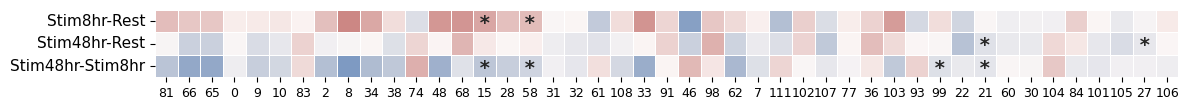

In [319]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(12, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()

In [12]:
downstream_gene_df

,hdbscan_cluster,downstream_gene,downstream_gene_ids,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
0,21,DPM1,ENSG00000000419,10,-1.000000,451,9601
1,21,SCYL3,ENSG00000000457,14,0.857143,7981,2071
2,21,C1orf112,ENSG00000000460,5,-0.600000,2234,7818
3,21,CFH,ENSG00000000971,2,1.000000,6036,4016
4,21,FUCA2,ENSG00000001036,5,1.000000,4869,5183
...,...,...,...,...,...,...,...
1577,23,PIGW,ENSG00000277161,4,1.000000,1540,43
1578,23,CCL3,ENSG00000277632,1,1.000000,762,821
1579,23,TRAC,ENSG00000277734,1,1.000000,714,868
1580,23,PAGR1,ENSG00000280789,1,-1.000000,32,1551


### Simple ideas of expression rebound

In [216]:
top_percentage = 0.05
cl = 77
regulators = adata_final.obs[adata_final.obs['hdbscan']==cl]['target_contrast_gene_name_corrected'].unique().tolist()
#cl = 36
cluster_df = downstream_gene_df[downstream_gene_df['hdbscan_cluster'] == cl].copy()
total_genes = len(cluster_df)
num_top_genes = max(1, int(total_genes * top_percentage))
downstream_genes = cluster_df[(cluster_df.zscore_rank_negative_regulation<num_top_genes)|(cluster_df.zscore_rank_positive_regulation<num_top_genes)].downstream_gene.tolist()
temp = de_summary_stats['target_name_corrected'].value_counts()
downstream_genes = list(set(downstream_genes) & set(temp[temp==3].index))
exp_rest = pd.DataFrame(de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_name_corrected').loc[downstream_genes]['baseMean'])
exp_rest = exp_rest.rename(columns={'baseMean':'baseMean_rest'})
exp_stim8 = pd.DataFrame(de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_name_corrected').loc[downstream_genes]['baseMean'])
exp_stim8 = exp_stim8.rename(columns={'baseMean':'baseMean_stim8hr'})
exp_stim48 = pd.DataFrame(de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_name_corrected').loc[downstream_genes]['baseMean'])
exp_stim48 = exp_stim48.rename(columns={'baseMean':'baseMean_stim48hr'})
zscore_rest = pd.DataFrame(data=adata_de[(adata_de.obs.culture_condition=='Rest')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
    adata_de.var.gene_name.isin(downstream_genes)].layers['masked_zscore'].mean(0),
                           index=adata_de[(adata_de.obs.culture_condition=='Rest')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
                               adata_de.var.gene_name.isin(downstream_genes)].var.gene_name,
                           columns=['zscore_rest']
                          )
zscore_stim8 = pd.DataFrame(data=adata_de[(adata_de.obs.culture_condition=='Stim8hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
    adata_de.var.gene_name.isin(downstream_genes)].layers['masked_zscore'].mean(0),
                           index=adata_de[(adata_de.obs.culture_condition=='Stim8hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
                               adata_de.var.gene_name.isin(downstream_genes)].var.gene_name,
                           columns=['zscore_stim8hr']
                          )
zscore_stim48 = pd.DataFrame(data=adata_de[(adata_de.obs.culture_condition=='Stim48hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
    adata_de.var.gene_name.isin(downstream_genes)].layers['masked_zscore'].mean(0),
                           index=adata_de[(adata_de.obs.culture_condition=='Stim48hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(regulators)),
                               adata_de.var.gene_name.isin(downstream_genes)].var.gene_name,
                           columns=['zscore_stim48hr']
                          )
df_exp_zscore = pd.merge(exp_rest, exp_stim8, left_index=True, right_index=True)
df_exp_zscore = pd.merge(df_exp_zscore, exp_stim48, left_index=True, right_index=True)
df_exp_zscore = pd.merge(df_exp_zscore, zscore_rest, left_index=True, right_index=True)
df_exp_zscore = pd.merge(df_exp_zscore, zscore_stim8, left_index=True, right_index=True)
df_exp_zscore = pd.merge(df_exp_zscore, zscore_stim48, left_index=True, right_index=True)

In [217]:
thres = 0.6
    
np.random.seed(100)
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genelist = set(genelist) & set(adata_de.obs.target_contrast_corrected.value_counts()[adata_de.obs.target_contrast_corrected.value_counts()==3].index)
regulator = list(genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_df_all.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


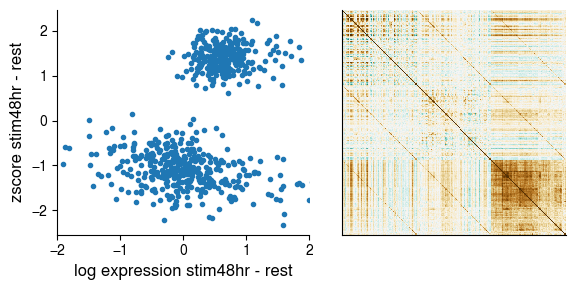

In [219]:
cond1 = 'stim48hr'
cond2 = 'rest'
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(np.log(df_exp_zscore['baseMean_'+cond1])-np.log(df_exp_zscore['baseMean_'+cond2]), df_exp_zscore['zscore_'+cond1]-df_exp_zscore['zscore_'+cond2], '.')
#plt.xlim([-100,100])
ax[0].set_xlabel('log expression '+cond1+' - '+cond2, fontsize=12)
ax[0].set_ylabel('zscore '+cond1+' - '+cond2, fontsize=12)
ax[0].set_xlim([-2,2])
sns.heatmap(corr_df_all.loc[regulator_all, regulator_all],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax[1])
sns.despine()
plt.tight_layout()

In [ ]:


# Create figure with space for color bars
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[0.075, 1], height_ratios=[0.075, 1],
                      hspace=0.02, wspace=0.01)

ax_heatmap = fig.add_subplot(gs[1, 1])
ax_col_colors = fig.add_subplot(gs[0, 1], sharex=ax_heatmap)
ax_row_colors = fig.add_subplot(gs[1, 0], sharey=ax_heatmap)

# Create heatmap
sns.heatmap(corr_df_all.loc[regulator_all, regulator_all],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax_heatmap)

# Create color arrays - assign categories as numbers
n = len(regulator_all)
condition_list = np.array([item.split('_')[1] for item in regulator_all])
col_categories = np.empty(n)
col_categories[condition_list=='Rest'] = 0
col_categories[condition_list=='Stim8hr'] = 0.5
col_categories[condition_list=='Stim48hr'] = 1
row_categories = col_categories

# Create a custom colormap for the categories
colors = ['#527ca0', '#c35f5a', '#dea26b']  # Add more colors as needed
cmap = mcolors.ListedColormap(colors)

# Plot color bars with proper extent to align with heatmap
ax_col_colors.imshow([col_categories], aspect='auto', cmap=cmap, 
                     extent=[0, n, 0, 1])
ax_col_colors.set_xlim(0, n)
ax_col_colors.axis('off')

ax_row_colors.imshow([[c] for c in row_categories], aspect='auto', cmap=cmap,
                     extent=[0, 1, n, 0])
ax_row_colors.set_ylim(n, 0)
ax_row_colors.axis('off')

In [55]:
df_exp_zscore

,baseMean_rest,baseMean_stim8hr,baseMean_stim48hr,zscore_rest,zscore_stim8hr,zscore_stim48hr
ABCF2,23.260401,82.666935,38.513244,-0.831253,-4.560921,-1.069304
STAT1,502.328981,276.836811,311.002841,1.786101,13.802844,8.292494
LRCH4,91.949391,41.692703,80.773478,0.027258,8.973704,1.609652
NFKB2,96.947410,242.436193,265.444058,0.390596,10.944430,1.585201
PIGW,19.746320,75.677529,18.982073,-0.085489,-5.119225,-0.364554
...,...,...,...,...,...,...
P2RY8,104.688179,27.932670,61.892606,-0.686004,10.104633,2.606158
MBOAT7,34.307511,157.048469,197.245277,-0.959956,-5.726780,-2.980014
ARHGAP15,506.350353,145.283636,330.389880,1.583249,15.057441,4.517981
RBPJ,30.493705,128.414395,124.677992,-0.560600,-5.100720,-2.530671


target_name_corrected
ABCF2        82.666935
STAT1       276.836811
LRCH4        41.692703
NFKB2       242.436193
PIGW         75.677529
               ...    
P2RY8        27.932670
MBOAT7      157.048469
ARHGAP15    145.283636
RBPJ        128.414395
NCKAP1L      56.505114
Name: baseMean, Length: 769, dtype: float64

In [15]:
print(regulators)

['PLCG1', 'CD247', 'LCP2', 'ZAP70', 'CD3G', 'VAV1', 'ZBED3', 'BCAT2', 'CD3D', 'CD3E', 'LAT']


In [ ]:
top_percentage = 0.10
results = []
cluster_id = 22
regulators = adata_final.obs[adata_final.obs['hdbscan'] == cluster_id]['target_contrast_gene_name_corrected'].unique().tolist()
unique_clusters = downstream_gene_df['hdbscan_cluster'].unique()
cluster_df = downstream_gene_df[
    downstream_gene_df['hdbscan_cluster'] == cluster_id
].copy()

total_genes = len(cluster_df)
num_top_genes = max(1, int(total_genes * top_percentage))

top_neg_genes = cluster_df.sort_values(
    'zscore_rank_negative_regulation'
).head(num_top_genes)['downstream_gene'].tolist()

top_pos_genes = cluster_df.sort_values(
    'zscore_rank_positive_regulation'
).head(num_top_genes)['downstream_gene'].tolist()

downstream_genes = list(set(top_neg_genes + top_pos_genes))
       
for downstream_gene in downstream_genes:
    bm_df = de_summary_stats[
        (de_summary_stats['target_name'] == downstream_gene) &
        (de_summary_stats['condition'].isin(['Rest', 'Stim8hr']))
    ].set_index('condition')['baseMean']
    
    if 'Stim8hr' in bm_df.index and 'Rest' in bm_df.index:
        bm_diff = bm_df['Stim8hr'] - bm_df['Rest']
    else:
        print(f"Warning: BaseMean data missing for {downstream_gene}. Skipping.")
        continue

    adata_regulators = adata_de[
        adata_de.obs.target_contrast_gene_name_corrected.isin(regulators), :
    ]
    
    adata_pair = adata_regulators[:, downstream_gene].copy()

    zscores = adata_pair.layers['zscore'].flatten()
    conditions = adata_pair.obs['culture_condition'].values
    
    zscore_data = pd.DataFrame({'zscore': zscores, 'condition': conditions})

    mean_zscore_rest = zscore_data[
        zscore_data['condition'] == 'Rest'
    ]['zscore'].mean()
    
    mean_zscore_stim8hr = zscore_data[
        zscore_data['condition'] == 'Stim8hr'
    ]['zscore'].mean()
    
    zscore_diff = mean_zscore_stim8hr - mean_zscore_rest

results.append({
    'hdbscan_cluster': cluster_id,
    'downstream_gene': downstream_gene,
    'bm_diff': bm_diff,
    'zscore_diff': zscore_diff,
    'num_regulators': len(regulators),
})

In [ ]:
top_percentage = 0.10
results = []
cluster_id = 22
regulators = adata_final.obs[adata_final.obs['hdbscan'] == cluster_id]['target_contrast_gene_name_corrected'].unique().tolist()
unique_clusters = downstream_gene_df['hdbscan_cluster'].unique()
cluster_df = downstream_gene_df[
    downstream_gene_df['hdbscan_cluster'] == cluster_id
].copy()

total_genes = len(cluster_df)
num_top_genes = max(1, int(total_genes * top_percentage))

top_neg_genes = cluster_df.sort_values(
    'zscore_rank_negative_regulation'
).head(num_top_genes)['downstream_gene'].tolist()

top_pos_genes = cluster_df.sort_values(
    'zscore_rank_positive_regulation'
).head(num_top_genes)['downstream_gene'].tolist()

downstream_genes = list(set(top_neg_genes + top_pos_genes))
       
for downstream_gene in downstream_genes:
    bm_df = de_summary_stats[
        (de_summary_stats['obs_names'] == downstream_gene) &
        (de_summary_stats['condition'].isin(['Rest', 'Stim8hr']))
    ].set_index('condition')['baseMean']
    
    if 'Stim8hr' in bm_df.index and 'Rest' in bm_df.index:
        bm_diff = bm_df['Stim8hr'] - bm_df['Rest']
    else:
        print(f"Warning: BaseMean data missing for {downstream_gene}. Skipping.")
        continue

    adata_regulators = adata_de[
        adata_de.obs.target_contrast_gene_name_corrected.isin(regulators), :
    ]
    
    if downstream_gene not in adata_regulators.var_names:
        print(f"Warning: Downstream gene {downstream_gene} not found in adata_de.var_names. Skipping.")
        continue
    
    adata_pair = adata_regulators[:, downstream_gene].copy()

    zscores = adata_pair.layers['zscore'].flatten()
    conditions = adata_pair.obs['culture_condition'].values
    
    zscore_data = pd.DataFrame({'zscore': zscores, 'condition': conditions})

    mean_zscore_rest = zscore_data[
        zscore_data['condition'] == 'Rest'
    ]['zscore'].mean()
    
    mean_zscore_stim8hr = zscore_data[
        zscore_data['condition'] == 'Stim8hr'
    ]['zscore'].mean()
    
    zscore_diff = mean_zscore_stim8hr - mean_zscore_rest

results.append({
    'hdbscan_cluster': cluster_id,
    'downstream_gene': downstream_gene,
    'bm_diff': bm_diff,
    'zscore_diff': zscore_diff,
    'num_regulators': len(regulators),
})

# --- 4. Execute Analysis and Plotting ---

# Run the analysis
analysis_results = analyze_gene_regulator_pairs(
    adata_final, downstream_gene_df, de_summary_stats, adata_de, TOP_PERCENTAGE
)

print("\n--- Analysis Complete ---")
print(f"Final results shape: {analysis_results.shape}")
print(analysis_results.head())

# Plot the results
plt.figure(figsize=(10, 8))
# Use seaborn for a nice looking scatter plot
scatter_plot = sns.scatterplot(
    data=analysis_results,
    x='zscore_diff',
    y='bm_diff',
    hue='hdbscan_cluster',  # Color by cluster
    size='num_regulators',  # Size by number of regulators (optional, but informative)
    palette='viridis',
    legend='full',
    alpha=0.7
)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.title(
    f'BaseMean vs. Z-Score Difference for Top {TOP_PERCENTAGE*100:.0f}% Downstream Genes',
    fontsize=14
)
plt.xlabel('Mean Regulator Z-Score Difference (Stim8hr - Rest)', fontsize=12)
plt.ylabel('Downstream Gene BaseMean Difference (Stim8hr - Rest)', fontsize=12)

# Annotate some points if the dataset were larger, here we just show the plot.
# Example annotation (uncomment if you want to label points):
# for i, row in analysis_results.iterrows():
#     if abs(row['bm_diff']) > 400 or abs(row['zscore_diff']) > 1.5: # Annotate outliers
#         plt.annotate(
#             row['downstream_gene'],
#             (row['zscore_diff'], row['bm_diff']),
#             textcoords="offset points", xytext=(0,10), ha='center',
#             fontsize=8
#         )

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Save the final data for external use
analysis_results.to_csv('gene_regulator_plot_data.csv', index=False)
print("\nResults saved to 'gene_regulator_plot_data.csv'.")

In [228]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['RPTOR', 'THAP2', 'CLDN7', 'UBA2'])].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000141564_Rest,RPTOR,Rest,ENSG00000141564,103,283.0,ENSG00000141564,RPTOR,51
ENSG00000173451_Rest,THAP2,Rest,ENSG00000173451,113,552.0,ENSG00000173451,THAP2,24
ENSG00000141564_Stim48hr,RPTOR,Stim48hr,ENSG00000141564,152,219.0,ENSG00000141564,RPTOR,31
ENSG00000173451_Stim8hr,THAP2,Stim8hr,ENSG00000173451,195,505.0,ENSG00000173451,THAP2,24
ENSG00000126261_Stim8hr,UBA2,Stim8hr,ENSG00000126261,219,77.0,ENSG00000126261,UBA2,-1
ENSG00000141564_Stim8hr,RPTOR,Stim8hr,ENSG00000141564,326,276.0,ENSG00000141564,RPTOR,32
ENSG00000181885_Stim48hr,CLDN7,Stim48hr,ENSG00000181885,327,540.0,ENSG00000181885,CLDN7,99
ENSG00000181885_Rest,CLDN7,Rest,ENSG00000181885,328,507.0,ENSG00000181885,CLDN7,-1
ENSG00000126261_Stim48hr,UBA2,Stim48hr,ENSG00000126261,346,55.0,ENSG00000126261,UBA2,-1
ENSG00000173451_Stim48hr,THAP2,Stim48hr,ENSG00000173451,355,733.0,ENSG00000173451,THAP2,24


In [231]:
adata_final[adata_final.obs.hdbscan==51].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000169020_Rest,ATP5ME,Rest,ENSG00000169020,51,234.0,ENSG00000169020,ATP5ME,51
ENSG00000152684_Rest,PELO,Rest,ENSG00000152684,73,494.0,ENSG00000152684,PELO,51
ENSG00000033011_Rest,ALG1,Rest,ENSG00000033011,80,72.0,ENSG00000033011,ALG1,51
ENSG00000168769_Rest,TET2,Rest,ENSG00000168769,98,1018.0,ENSG00000168769,TET2,51
ENSG00000141564_Rest,RPTOR,Rest,ENSG00000141564,103,283.0,ENSG00000141564,RPTOR,51
ENSG00000189007_Rest,ADAT2,Rest,ENSG00000189007,198,298.0,ENSG00000189007,ADAT2,51
ENSG00000164654_Rest,MIOS,Rest,ENSG00000164654,228,84.0,ENSG00000164654,MIOS,51
ENSG00000178802_Rest,MPI,Rest,ENSG00000178802,237,226.0,ENSG00000178802,MPI,51
ENSG00000169230_Rest,PRELID1,Rest,ENSG00000169230,248,149.0,ENSG00000169230,PRELID1,51
ENSG00000158615_Rest,PPP1R15B,Rest,ENSG00000158615,253,184.0,ENSG00000158615,PPP1R15B,51


In [230]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['ADM5'])].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan


In [236]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['TSC1', 'TSC2', 'NPRL3', 'DEPDC5','CYB561D2','JAK2'])].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000103197_Rest,TSC2,Rest,ENSG00000103197,142,631.0,ENSG00000103197,TSC2,101
ENSG00000114395_Rest,CYB561D2,Rest,ENSG00000114395,302,901.0,ENSG00000114395,CYB561D2,101
ENSG00000165699_Rest,TSC1,Rest,ENSG00000165699,325,492.0,ENSG00000165699,TSC1,101
ENSG00000114395_Stim8hr,CYB561D2,Stim8hr,ENSG00000114395,440,926.0,ENSG00000114395,CYB561D2,21
ENSG00000165699_Stim8hr,TSC1,Stim8hr,ENSG00000165699,440,371.0,ENSG00000165699,TSC1,21
ENSG00000165699_Stim48hr,TSC1,Stim48hr,ENSG00000165699,462,309.0,ENSG00000165699,TSC1,77
ENSG00000103197_Stim48hr,TSC2,Stim48hr,ENSG00000103197,548,484.0,ENSG00000103197,TSC2,77
ENSG00000103197_Stim8hr,TSC2,Stim8hr,ENSG00000103197,583,469.0,ENSG00000103197,TSC2,21


In [252]:
de_summary_stats[de_summary_stats.target_name.isin(['TSC1', 'TSC2', 'NPRL3', 'DEPDC5','CYB561D2',
                                                   'RPTOR', 'THAP2', 'CLDN7', 'UBA2', 'ADM5','JAK2', 'CARD11'])]

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,target_name_corrected
obs_names,,,,,,,,,,,,,,,
ENSG00000096968_Stim48hr,ENSG00000096968,JAK2,Stim48hr,941.0,0,6,6,-19.731814,True,67.311804,False,2-10 DE genes,on-target KD,ENSG00000096968,JAK2
ENSG00000141564_Rest,ENSG00000141564,RPTOR,Rest,283.0,458,181,639,-3.109146,True,61.690896,False,>10 DE genes,on-target KD,ENSG00000141564,RPTOR
ENSG00000224420_Rest,ENSG00000224420,ADM5,Rest,2111.0,14,3,17,-0.017208,False,0.921295,False,>10 DE genes,no on-target KD,ENSG00000224420,ADM5
ENSG00000173451_Rest,ENSG00000173451,THAP2,Rest,552.0,86,8,94,-4.699610,True,9.581702,True,>10 DE genes,on-target KD,ENSG00000173451,THAP2
ENSG00000103197_Rest,ENSG00000103197,TSC2,Rest,631.0,577,524,1101,-10.287862,True,16.242152,True,>10 DE genes,on-target KD,ENSG00000103197,TSC2
ENSG00000141564_Stim48hr,ENSG00000141564,RPTOR,Stim48hr,219.0,95,27,122,-3.213862,False,48.223247,False,>10 DE genes,no on-target KD,ENSG00000141564,RPTOR
ENSG00000198286_Rest,ENSG00000198286,CARD11,Rest,69.0,29,72,101,-6.137260,True,77.100959,False,>10 DE genes,on-target KD,ENSG00000198286,CARD11
ENSG00000173451_Stim8hr,ENSG00000173451,THAP2,Stim8hr,505.0,160,10,170,-5.753547,True,14.291639,True,>10 DE genes,on-target KD,ENSG00000173451,THAP2
ENSG00000126261_Stim8hr,ENSG00000126261,UBA2,Stim8hr,77.0,230,38,268,-6.132744,True,132.747418,False,>10 DE genes,on-target KD,ENSG00000126261,UBA2


In [237]:
adata_final = sc.read_h5ad(datadir + '/analysis_largefiles/nde50ntotal50_varfiltered_simple_clustering.h5ad', backed='r')

In [255]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='LCK'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000182866_Stim8hr,LCK,Stim8hr,ENSG00000182866,59,116.0,ENSG00000182866,LCK,19
ENSG00000182866_Stim48hr,LCK,Stim48hr,ENSG00000182866,432,107.0,ENSG00000182866,LCK,124
ENSG00000182866_Rest,LCK,Rest,ENSG00000182866,459,102.0,ENSG00000182866,LCK,133


In [240]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='CD3D'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000167286_Stim8hr,CD3D,Stim8hr,ENSG00000167286,436,185.0,ENSG00000167286,CD3D,20
ENSG00000167286_Stim48hr,CD3D,Stim48hr,ENSG00000167286,634,85.0,ENSG00000167286,CD3D,124


In [243]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='CD28'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000178562_Stim8hr,CD28,Stim8hr,ENSG00000178562,99,675.0,ENSG00000178562,CD28,19
ENSG00000178562_Stim48hr,CD28,Stim48hr,ENSG00000178562,401,514.0,ENSG00000178562,CD28,127


In [244]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='CD2'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000116824_Stim48hr,CD2,Stim48hr,ENSG00000116824,64,478.0,ENSG00000116824,CD2,124
ENSG00000116824_Stim8hr,CD2,Stim8hr,ENSG00000116824,675,378.0,ENSG00000116824,CD2,54


In [241]:
adata_final[adata_final.obs.hdbscan==-1].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000158435_Stim48hr,CNOT11,Stim48hr,ENSG00000158435,1,120.0,ENSG00000158435,CNOT11,-1
ENSG00000175155_Stim8hr,YPEL2,Stim8hr,ENSG00000175155,3,729.0,ENSG00000175155,YPEL2,-1
ENSG00000010539_Stim8hr,ZNF200,Stim8hr,ENSG00000010539,4,930.0,ENSG00000010539,ZNF200,-1
ENSG00000104835_Rest,SARS2,Rest,ENSG00000104835,6,450.0,ENSG00000104835,SARS2,-1
ENSG00000106682_Rest,EIF4H,Rest,ENSG00000106682,6,380.0,ENSG00000106682,EIF4H,-1
...,...,...,...,...,...,...,...,...
ENSG00000205209_Stim8hr,SCGB2B2,Stim8hr,ENSG00000205209,675,619.0,ENSG00000205209,SCGB2B2,-1
ENSG00000105397_Stim48hr,TYK2,Stim48hr,ENSG00000105397,677,941.0,ENSG00000105397,TYK2,-1
ENSG00000164466_Stim48hr,SFXN1,Stim48hr,ENSG00000164466,677,728.0,ENSG00000164466,SFXN1,-1
ENSG00000171720_Stim48hr,HDAC3,Stim48hr,ENSG00000171720,677,210.0,ENSG00000171720,HDAC3,-1


In [247]:
print(adata_final[adata_final.obs.hdbscan==19].obs.target_contrast_gene_name_corrected.tolist())

['PLAT', 'COG5', 'ATXN7L3', 'EML2', 'USP22', 'RAC2', 'CAMSAP1', 'LCK', 'RAB19', 'DCAF11', 'TMEM205', 'ACTR2', 'FAM204A', 'NUDCD1', 'CDS2', 'NUDCD1', 'SYK', 'CD28', 'PDS5B', 'SCAF4', 'ZNF790', 'CRIPT', 'FZD6', 'PTPRC', 'SENP1', 'ATXN7L3', 'UBL7', 'PPP1R15B', 'CSH1', 'BCL10', 'KIDINS220', 'BRPF1', 'ATP2A3', 'PPP3R1', 'SKIC2', 'WAS', 'AIRIM', 'TMX1', 'SLC3A2', 'IKZF1', 'PIGB', 'SPTLC2', 'RANBP3', 'CBLL1', 'PHF19', 'SRP9', 'DIPK1A', 'ABCC1', 'SHOC2', 'FLVCR2', 'UBE2E2', 'EIF4G2', 'MEMO1', 'LRBA', 'VPS41', 'KIF16B', 'SLC7A6', 'ZSCAN23', 'UHRF1', 'RAVER1', 'TASOR', 'MED23', 'SRP14', 'ZFP82', 'ARID4B', 'ING5', 'PDIA3', 'KCTD21', 'HACD4', 'DZIP1', 'ANKRD61', 'MCFD2', 'HSD17B12', 'CALCOCO2', 'TBC1D31', 'RPN1', 'BCAP29', 'KAT6A', 'ELP6', 'TLN1', 'SNAP29', 'WAPL', 'DDX60L', 'TBX22', 'ARPC2', 'ERCC6L2', 'EFR3A', 'TTYH3', 'FITM2', 'CDIPT', 'ARPC3', 'ABHD17A', 'NCBP3', 'PGGT1B', 'HELT', 'ARF4', 'TTC7A', 'COP1', 'PPP1R10', 'CYB5R4', 'SPATA33', 'KPNA4', 'MTA3', 'CYB561D2', 'PEX5', 'DCAF5', 'TSC1', 'AL

In [248]:
print(adata_final[adata_final.obs.hdbscan==54].obs.target_contrast_gene_name_corrected.tolist())

['IDH3A', 'SLC25A51', 'FAM20B', 'BRD1', 'PGS1', 'CMAS', 'MLLT3', 'IRF4', 'RNF145', 'RC3H1', 'ZC3H10', 'RPS19', 'DHX9', 'RAP2A', 'MSL2', 'HDAC7', 'ALDOA', 'BATF', 'TM9SF3', 'SND1', 'ARID1A', 'ATP5F1A', 'IBA57', 'KLF2', 'IRF2', 'ATP5PO', 'CABIN1', 'UGDH', 'TBX21', 'EXOC4', 'PGAM1', 'TFAP4', 'GOLGA8A', 'FLI1', 'MBTPS1', 'ELF4', 'BCL3', 'LRRC25', 'YY1', 'STAT5B', 'GET3', 'EGR2', 'IPMK', 'CDK2AP2', 'GPT2', 'GNG5', 'SCAF8', 'PAIP1', 'ERGIC1', 'RASA2', 'AKAP17A', 'GNAS', 'IMMP1L', 'FBXO11', 'BCL3', 'ATP23', 'CERT1', 'WDR44', 'FLAD1', 'MLST8', 'GET1', 'MBTPS2', 'OGT', 'PPA2', 'TET2', 'CDK2', 'PMVK', 'STAT3', 'WDR48', 'LRRC25', 'BHLHE40', 'EXOC7', 'FBXO28', 'ATP5ME', 'RNF7', 'CNOT4', 'UBR4', 'LRRC25', 'EIPR1', 'FBXO11', 'ACTB', 'CUL4B', 'RBSN', 'ITSN1', 'JUNB', 'CD2']
